In [1]:
from models.content_encoder import XLSR_ESPEAK_CTC
from models.pitch_encoder import YINEncoder
from models import DDDMPreprocessor
import util
import torch
from data import AudioDataloader, MSPPodcast, MelTransform
from config import load_hydra_config

from models.style_encoder import StyleEncoder

cfg = load_hydra_config("evc_xlsr_yin", overrides=["data.dataset.segment_size=38000"])
dataloader = AudioDataloader(
    dataset=MSPPodcast(cfg.data, split="train", random_segmentation=True),
    cfg=cfg.data.dataloader,
    batch_size=32,
    shuffle=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessor = DDDMPreprocessor(
    mel_transform=MelTransform(cfg.data.mel_transform),
    pitch_encoder=YINEncoder(cfg.model.pitch_encoder),
    content_encoder=XLSR_ESPEAK_CTC(
        return_logits=False,
        return_hidden=True,
    ),
    sample_rate=cfg.data.dataset.sampling_rate,
).to(device)

style_encoder = StyleEncoder(
    cfg.model.style_encoder,
).to(device)

util.load_model(
    style_encoder.speaker_encoder,
    "metastylespeech.pth",
    mode="eval",
    freeze=True,
)

In [24]:
import numpy as np

preprocessor.eval()
style_encoder.eval()

spk_embed = []
emo_embed = []
emo_label = []
spk_label = []

with torch.no_grad():
    for j, batch in enumerate(dataloader):
        if j > 100:
            break
        print(f"\rProcessing batch {j}", end="")
        audio, n_frames, labels = (
            batch[0].to(device, non_blocking=True),
            batch[1].to(device, non_blocking=True),
            batch[2].to(device, non_blocking=True),
        )
        x = preprocessor(audio, n_frames, labels)
        spk = style_encoder.speaker_encoder(x)
        spk_embed.append(spk.cpu().numpy())

        emo = style_encoder.emotion_encoder(x.audio, embeddings_only=True)
        emo_embed.append(emo.cpu().numpy())

        emo_label.append(x.label.label_tensor[:, 0:3].cpu().numpy())
        spk_label.append(x.label.spk_id.cpu().numpy())

spk_embed = np.concatenate(spk_embed, axis=0)
emo_embed = np.concatenate(emo_embed, axis=0)
emo_label = np.concatenate(emo_label, axis=0)
spk_label = np.concatenate(spk_label, axis=0)

Processing batch 100

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
import matplotlib.pyplot as plt


def plot_tsne(emb):
    X = StandardScaler().fit_transform(emb)

    tsne = TSNE(n_components=2, perplexity=40, init='pca',
                learning_rate='auto', random_state=0, angle=0.6, n_jobs=4)
    X2d = tsne.fit_transform(X)

    plt.figure(figsize=(6,6))
    plt.scatter(X2d[:,0], X2d[:,1], c=spk_label, cmap='tab20', s=10)  # speakers
    plt.title('t‑SNE – coloured by speaker'); plt.axis('off')
    plt.show()

    for i, emo in enumerate(["valence", "arousal", "dominance"]):
        plt.figure(figsize=(6,6))
        plt.scatter(X2d[:,0], X2d[:,1], c=emo_label[:, i], cmap='plasma', s=10)  # emotions
        plt.title(f't‑SNE – coloured by {emo}'); plt.axis('off')
        plt.show()
    # plt.figure(figsize=(6,6))
    # plt.scatter(X2d[:, 0], X2d[:, 1], c=vad, s=40, alpha=0.45, linewidths=0)  # no cmap argument
    # plt.title('t‑SNE – colour = (V,A,D)'); plt.axis('off')
    # plt.show()

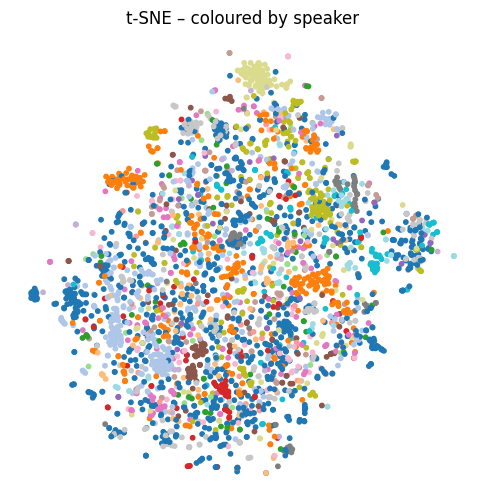

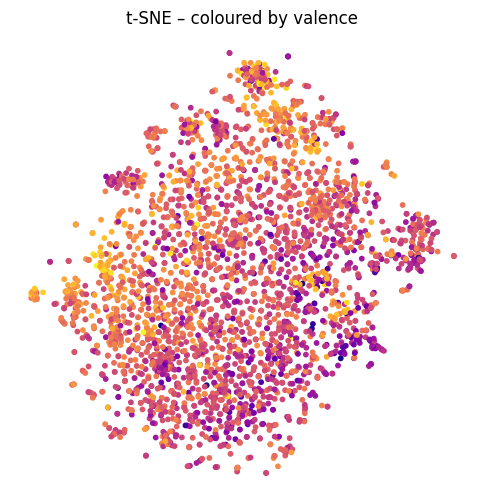

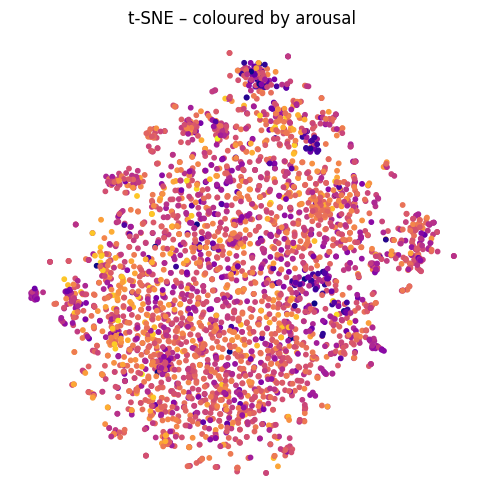

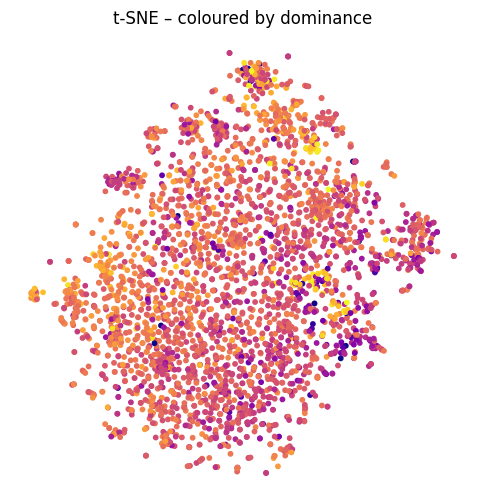

In [54]:
plot_tsne(spk_embed)

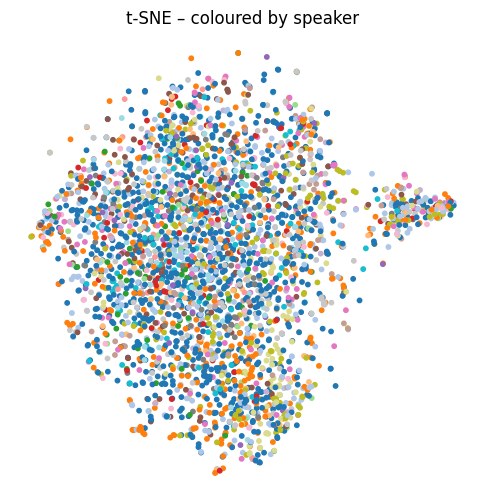

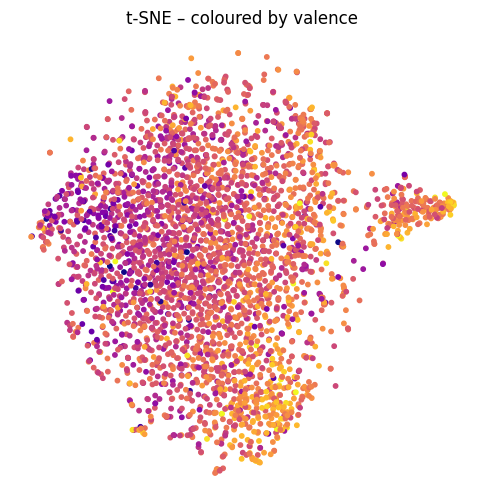

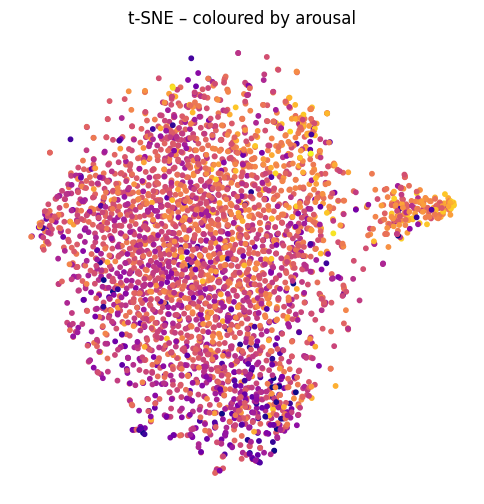

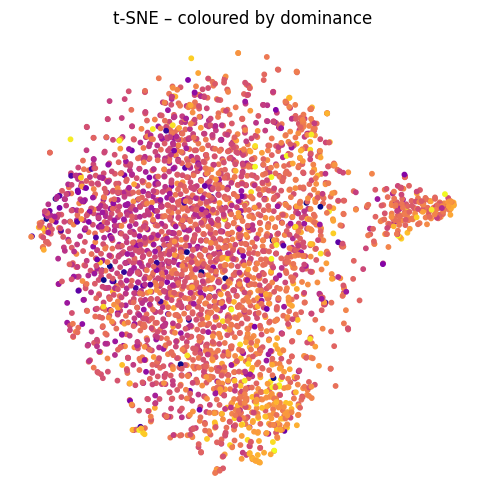

In [55]:
plot_tsne(emo_embed)

In [ ]:

# --- Numeric metrics (original space) -------------------------------------
print('Silhouette (speaker):          ', silhouette_score(X, spk_label))
print('Calinski‑Harabasz (speaker):   ', calinski_harabasz_score(X, spk_label))
print('Davies‑Bouldin  (speaker):     ', davies_bouldin_score(X, spk_label))

for i, lab in enumerate(dims):
    print("---" * 10)
    print(f'Silhouette ({lab}):          ', silhouette_score(X, emo_label[:, i]))
    print(f'Calinski‑Harabasz ({lab}):   ', calinski_harabasz_score(X, emo_label[:, i]))
    print(f'Davies‑Bouldin  ({lab}):     ', davies_bouldin_score(X, emo_label[:, i]))
    print('ARI speaker vs emotion labels: ', adjusted_rand_score(spk_label, emo_label[:, i]))